In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [ ]:
df = pd.read_excel("data/Aufgabe_1_Gloss_Optimization.xlsx")
df

,V13,V15,V16,V18,V19,V21,V28,V29,V30,V31,V32,V33,V34,V39,gloss
0,0.10,HMW 1,0.05,LMW 1,0.05,LMW 6,-0.004681,0.103880,0.000972,-0.005881,0.055534,0.058750,-0.004681,8,6200
1,0.12,HMW 1,0.04,LMW 1,0.04,LMW 6,-0.010345,0.112653,0.001479,0.005503,0.040954,0.056777,-0.010345,8,6400
2,0.12,HMW 1,0.06,LMW 1,0.02,LMW 6,-0.005359,0.125634,0.003815,-0.012599,0.074109,0.015341,-0.005359,8,5800
3,0.14,HMW 1,0.04,LMW 1,0.02,LMW 6,-0.004240,0.147946,-0.016650,0.010005,0.039433,0.018663,-0.004240,6,6200
4,0.28,HMW 1,0.08,LMW 1,0.04,LMW 6,-0.026882,0.284841,-0.009568,-0.019216,0.068883,0.038201,-0.026882,8,8600
5,0.12,HMW 1,0.06,LMW 1,0.02,LMW 7,-0.012378,0.131851,-0.009754,0.003244,0.059373,0.026450,-0.012378,8,4800
6,0.24,HMW 1,0.12,LMW 1,0.04,LMW 7,-0.003660,0.244951,0.016939,-0.012309,0.123884,0.042937,-0.003660,8,6800
7,0.14,HMW 1,0.04,LMW 1,0.02,LMW 7,0.006664,0.125695,-0.004785,-0.004625,0.037321,0.018528,0.006664,6,4000
8,0.28,HMW 1,0.08,LMW 1,0.04,LMW 7,0.018571,0.288215,-0.007519,0.003315,0.079077,0.046381,0.018571,8,6600
9,0.10,HMW 1,0.05,LMW 1,0.05,LMW 3,0.007331,0.103919,0.002864,-0.014808,0.067368,0.005788,0.007331,8,7300


In [4]:
df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V13     58 non-null     float64
 1   V15     58 non-null     object 
 2   V16     58 non-null     float64
 3   V18     49 non-null     object 
 4   V19     58 non-null     float64
 5   V21     15 non-null     object 
 6   V28     58 non-null     float64
 7   V29     58 non-null     float64
 8   V30     58 non-null     float64
 9   V31     58 non-null     float64
 10  V32     58 non-null     float64
 11  V33     58 non-null     float64
 12  V34     58 non-null     float64
 13  V39     58 non-null     int64  
 14  gloss   58 non-null     int64  
dtypes: float64(10), int64(2), object(3)
memory usage: 6.9+ KB


V13       0
V15       0
V16       0
V18       9
V19       0
V21      43
V28       0
V29       0
V30       0
V31       0
V32       0
V33       0
V34       0
V39       0
gloss     0
dtype: int64

In [5]:
# Drop V21 because of too many missing values
df = df.drop(columns=["V21"])

# Handle missing values in V18
# Option 1: Replace NaN with "Missing"
df["V18"] = df["V18"].fillna("Missing")

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df, columns=["V15", "V18"], drop_first=True)

# Split features/target
X = df_encoded.drop("gloss", axis=1)
y = df_encoded["gloss"]

# Scale features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

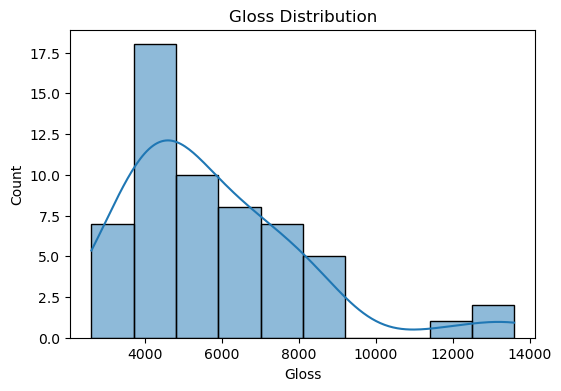

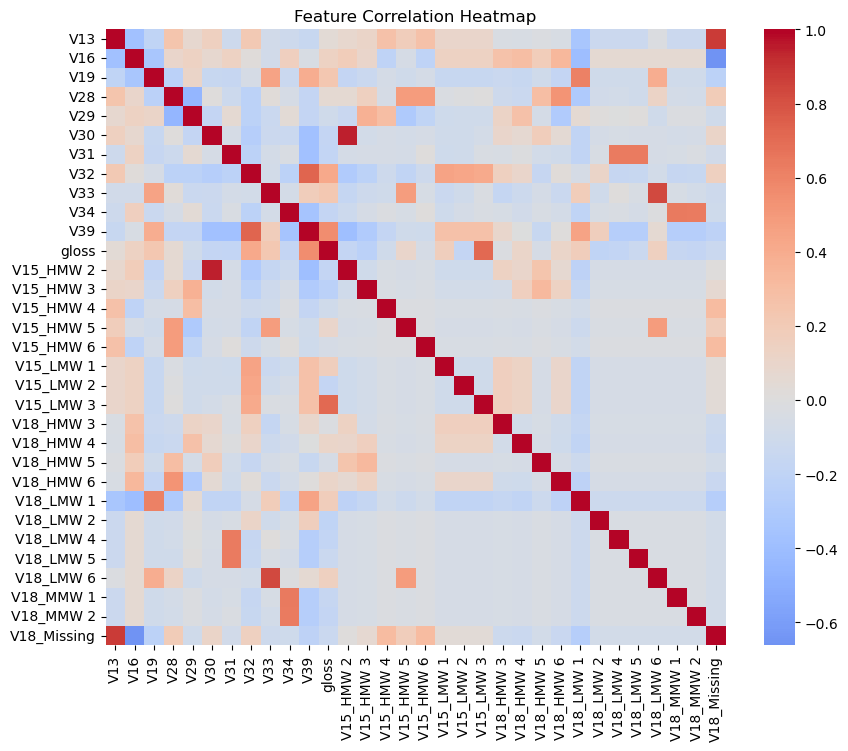

Correlation of features with gloss:
 gloss          1.000000
V15_LMW 3      0.712937
V39            0.554567
V32            0.419360
V19            0.228708
V33            0.221077
V18_LMW 1      0.170556
V15_LMW 1      0.163239
V18_LMW 6      0.154392
V16            0.138185
V18_HMW 4      0.108270
V18_HMW 6      0.106229
V15_HMW 5      0.102049
V28            0.063715
V13            0.040160
V18_HMW 3     -0.024095
V18_HMW 5     -0.054981
V15_HMW 6     -0.058289
V15_HMW 4     -0.092154
V29           -0.102683
V18_LMW 5     -0.135510
V18_Missing   -0.135846
V18_MMW 1     -0.155642
V30           -0.168900
V15_HMW 2     -0.171198
V34           -0.172249
V18_MMW 2     -0.175774
V15_LMW 2     -0.177050
V18_LMW 4     -0.183827
V31           -0.185285
V18_LMW 2     -0.199932
V15_HMW 3     -0.232848
Name: gloss, dtype: float64


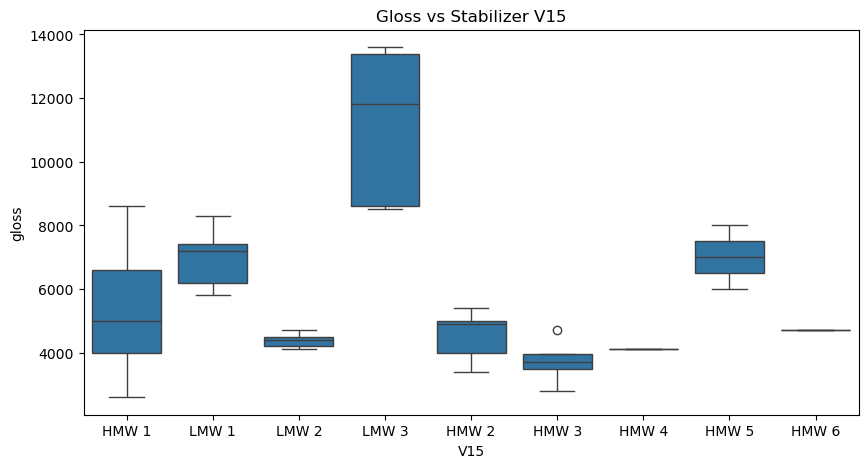

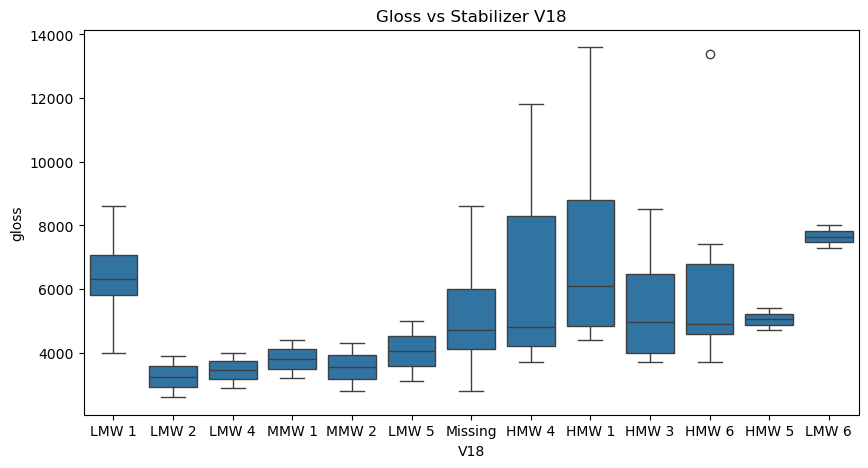

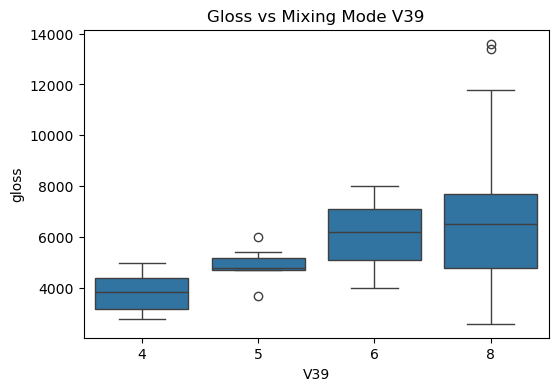

In [6]:
# 1. Distribution of target variable (gloss)
plt.figure(figsize=(6,4))
sns.histplot(y, kde=True, bins=10)
plt.title("Gloss Distribution")
plt.xlabel("Gloss")
plt.ylabel("Count")
plt.show()

# 2. Correlation heatmap (numerical features only)
plt.figure(figsize=(10,8))
corr = df_encoded.corr()
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

# 3. Correlation of each feature with gloss
corr_target = corr["gloss"].sort_values(ascending=False)
print("Correlation of features with gloss:\n", corr_target)

# 4. Boxplots for categorical variables (before encoding)
plt.figure(figsize=(10,5))
sns.boxplot(x="V15", y="gloss", data=df)
plt.title("Gloss vs Stabilizer V15")
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(x="V18", y="gloss", data=df)
plt.title("Gloss vs Stabilizer V18")
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(x="V39", y="gloss", data=df)
plt.title("Gloss vs Mixing Mode V39")
plt.show()

In [7]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Baseline Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predictions
y_pred = lr.predict(X_test)

# Evaluation
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Linear Regression R²:", r2)
print("Linear Regression RMSE:", rmse)

# Cross-validation (k=5)
cv_scores = cross_val_score(lr, X_scaled, y, cv=5, scoring="r2")
print("CV R² scores:", cv_scores)
print("Mean CV R²:", cv_scores.mean())

Linear Regression R²: 0.3814113137888576
Linear Regression RMSE: 1659.1839813083411
CV R² scores: [ -4.28253089  -3.63406107 -11.64066448  -0.6378826   -0.93147395]
Mean CV R²: -4.225322599674878
